# Sprawozdanie z Laboratorium 10
## Autorzy: Mateusz Pawliczek, Piotr Świerzy  
## Data: 03.06.2025

# Przed zadaniami
zaimplementujemy funkcje m.in. na metody numeryczne potrzebne w zadaniach. Zaimportujemy również portrzebne biblioteki.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, minimize

In [11]:
# Parametry modelu
alpha1, alpha2 = 1, 0.5
beta1, beta2 = 0.1, 0.02
x0, y0 = 20, 20
T, h = 80, 0.1
N = int(T/h)

# Funkcje pochodnych
def dx(x, y): return x * (alpha1 - beta1 * y)
def dy(x, y): return y * (-alpha2 + beta2 * x)

Zacznijmy od **jawnej metody Eulera**
$$
x_{k+1} = x_k + h \cdot dx(x_k, y_k) \newline
y_{k+1} = y_k + h \cdot dy(x_k, y_k)
$$

In [12]:
def euler_explicit():
    x, y = np.zeros(N), np.zeros(N)
    x[0], y[0] = x0, y0
    for n in range(N-1):
        x[n+1] = x[n] + h * dx(x[n], y[n])
        y[n+1] = y[n] + h * dy(x[n], y[n])
    return x, y

Teraz **pół jawną metodę Eulera**
$$
x_{k+1} = x_k + h \cdot dx(x_k, y_{k+1}) \newline
y_{k+1} = y_k + h \cdot dy(x_k, y_{k+1}) \newline => 
y_{k+1} = y_k + h \cdot y_{k+1} (\beta _2x_k - \alpha _2)\newline => 
y_{k+1} (1 + h\alpha _2 - h\beta _2x_k) = y_k \newline =>
y_{k+1} = \frac{y_k}{1 + h\alpha _2 - h\beta _2x_k}
$$

In [13]:
def euler_semi_implicit():
    x, y = np.zeros(N), np.zeros(N)
    x[0], y[0] = x0, y0
    for n in range(N-1):
        y[n+1] = y[n] / (1 - h * (-alpha2 + beta2 * x[n]))
        x[n+1] = x[n] + h * dx(x[n], y[n+1])
    return x, y

Teraz **niejawną metodę Eulera**
$$
x_{k+1} = x_k + h \cdot dx(x_{k+1}, y_{k+1}) \newline
y_{k+1} = y_k + h \cdot dy(x_{k+1}, y_{k+1}) => \newline
x_{k+1} - x_k - hx_{k+1}(\alpha _1-\beta _1y_{k+1}) = 0 \newline
y_{k+1} - y_k - hy_{k+1}(-\alpha _2+\beta _2x_{k+1}) = 0
$$
Powyższy układ równań rozwiązujemy za pomocą `fsolve`.

In [14]:
def euler_implicit():
    x, y = np.zeros(N), np.zeros(N)
    x[0], y[0] = x0, y0
    
    def equation(next, prev):
        x_n, y_n = next
        x_p, y_p = prev
        return [x_n-x_p- h*(alpha1 - beta1*y_n), y_n-y_p- h*(-alpha2 + beta2*x_n)]
    
    for n in range(N-1):
        sol = fsolve(equation, [x[n], y[n]], args=([x[n], y[n]]))
        x[n+1], y[n+1] = sol
    return x, y

I ostatnia została **metoda Rungego-Kutty czwartego rzędu**
$$
x_{k+1} = x_k + \frac{h}{6} (k_1^x+2k_2^x+2k_3^x+k_4^)\newline
y_{k+1} = y_k + \frac{h}{6} (k_1^y+2k_2^y+2k_3^y+k_4^y)\newline
k_1^x = dx(x_k, y_k)\newline
k_1^y = dy(x_k, y_k)\newline
k_2^x = dx(x_k + \frac{h \cdot k_1^x}{2}, y_k + \frac{h \cdot k_1^y}{2})\newline
k_2^y = dy(x_k + \frac{h \cdot k_1^x}{2}, y_k + \frac{h \cdot k_1^y}{2})\newline
k_3^x = dx(x_k + \frac{h \cdot k_2^x}{2}, y_k + \frac{h \cdot k_2^y}{2})\newline
k_3^y = dy(x_k + \frac{h \cdot k_2^x}{2}, y_k + \frac{h \cdot k_2^y}{2})\newline
k_4^x = dx(x_k + h \cdot k_3^x, y_k + h \cdot k_3^y)\newline
k_4^y = dy(x_k + h \cdot k_3^x, y_k + h \cdot k_3^y)\newline
$$

In [15]:
def rk4():
    x, y = np.zeros(N), np.zeros(N)
    x[0], y[0] = x0, y0
    for n in range(N-1):
        k1x, k1y = dx(x[n], y[n]), dy(x[n], y[n])
        k2x = dx(x[n] + h*k1x/2, y[n] + h*k1y/2)
        k2y = dy(x[n] + h*k1x/2, y[n] + h*k1y/2)
        k3x = dx(x[n] + h*k2x/2, y[n] + h*k2y/2)
        k3y = dy(x[n] + h*k2x/2, y[n] + h*k2y/2)
        k4x = dx(x[n] + h*k3x, y[n] + h*k3y)
        k4y = dy(x[n] + h*k3x, y[n] + h*k3y)
        x[n+1] = x[n] + h * (k1x + 2*k2x + 2*k3x + k4x)/6
        y[n+1] = y[n] + h * (k1y + 2*k2y + 2*k3y + k4y)/6
    return x, y

## (a) Wykresy
Na wspólnym rysunku narysuj wykresy liczebności obu populacji w zależności od czasu.\
Na osobnym rysunku narysuj portret fazowy układu, tj. wykres trajektorii punktu $(x(t), y(t))$ w funkcji czasu. Podaj jego fizyczną interpretację.

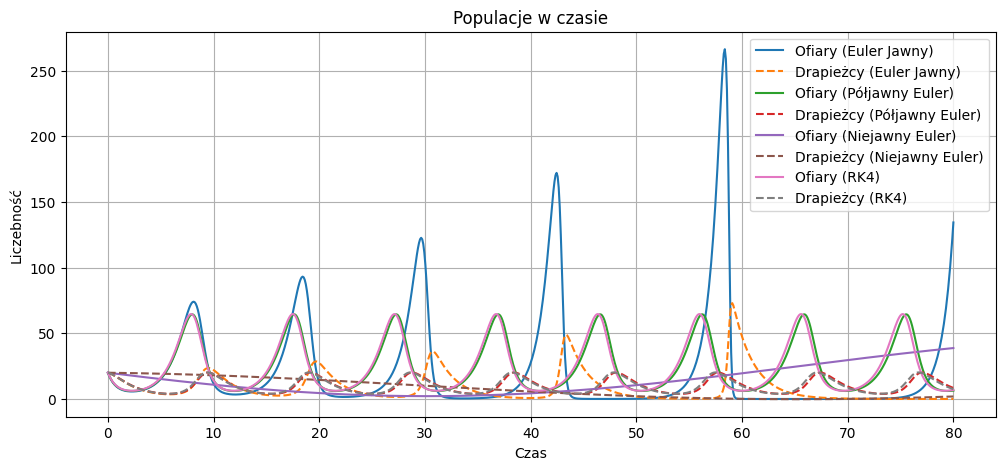

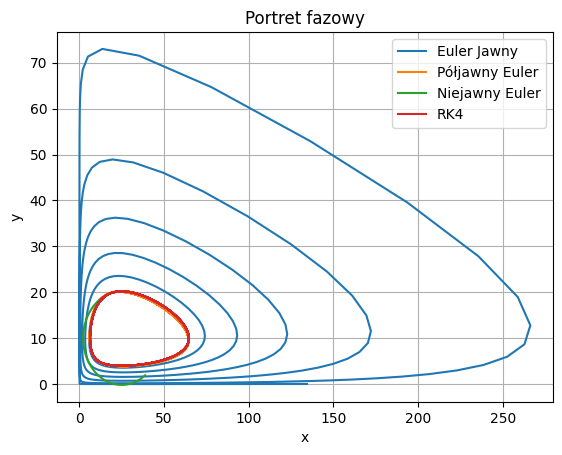

In [16]:
def plot_all_methods():
    t = np.linspace(0, T, N)
    methods = {
        'Euler Jawny': euler_explicit(),
        'Półjawny Euler': euler_semi_implicit(),
        'Niejawny Euler': euler_implicit(),
        'RK4': rk4()
    }

    plt.figure(figsize=(12, 5))
    for label, (x, y) in methods.items():
        plt.plot(t, x, label=f'Ofiary ({label})')
        plt.plot(t, y, '--', label=f'Drapieżcy ({label})')
    plt.xlabel('Czas'); plt.ylabel('Liczebność'); plt.title('Populacje w czasie')
    plt.legend(); plt.grid(); plt.show()

    plt.figure()
    for label, (x, y) in methods.items():
        plt.plot(x, y, label=label)
    plt.xlabel('x'); plt.ylabel('y'); plt.title('Portret fazowy'); 
    plt.legend(); plt.grid(); plt.show()

plot_all_methods()

## (b) Punkty stacjonarne
Dla jakich warunków początkowych liczebności populacji nie ulegają zmianie? Znajdź punkty stacjonarne powyższego układu, rozwiązując układ równań:
$$
x' = x(\alpha _1 - \beta _1y) = 0\newline
y' = y(-\alpha _2 + \beta _2x) = 0
$$

Oczywistym jest to, że $(x, y) = (0, 0)$ albo:
$$
\alpha _1 - \beta _1y = 0\newline
-\alpha _2 + \beta _2x = 0 \newline => \newline
x = \alpha _2/\beta _2\newline
y = \alpha _1/\beta _1
$$

## (c) Niezmiennik
Czy zachowany jest niezmiennik?
Na wspólnym rysunku przedstaw wykresy tego niezmiennika znalezione
przez każdą metodę numeryczną.
$$
H(x, y) = \beta _2x + \beta _1y - \alpha _2 ln(x) - \alpha _1 ln(y)
$$

C:\Users\piotr\AppData\Local\Temp\ipykernel_6004\855318104.py:2: RuntimeWarning: invalid value encountered in log
  return beta2 * x + beta1 * y - alpha2 * np.log(x) - alpha1 * np.log(y)


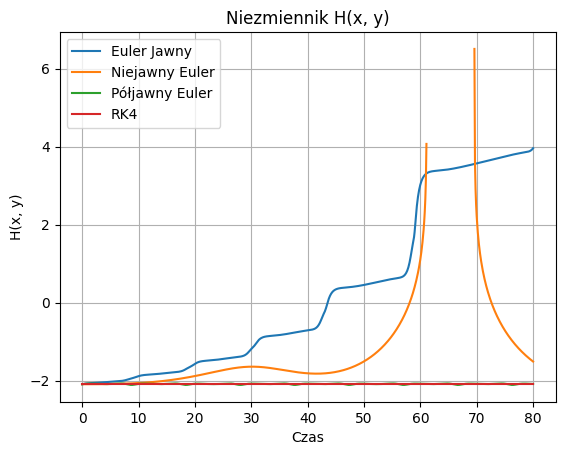

In [17]:
def invariant(x, y): 
    return beta2 * x + beta1 * y - alpha2 * np.log(x) - alpha1 * np.log(y)

def invariant_plot():
    t = np.linspace(0, T, N)
    methods = {
        'Euler Jawny': euler_explicit(),
        'Niejawny Euler': euler_implicit(),
        'Półjawny Euler': euler_semi_implicit(),
        'RK4': rk4()
    }
    plt.figure()
    for label, (x, y) in methods.items():
        H = invariant(x, y)
        plt.plot(t, H, label=label)
    plt.title("Niezmiennik H(x, y)")
    plt.xlabel("Czas"); plt.ylabel("H(x, y)"); plt.legend(); plt.grid(); plt.show()

invariant_plot()

## (d) Minimalizacja straty
Wiemy, że na przestrzeni lat populacja rysi i zajęcy kształtowała się wg
danych przedstawionych w pliku `LynxHare.txt`.
Wybierz jedną z powyższych metod numerycznych i oszacuj prawdziwe wartości współczynników θ = [α1, α2, β1, β2]. W tym celu wykonaj minimalizację funkcji kosztu. Jako funkcję kosztu wykorzystaj sumę kwadratów reszt (ang. residual sum of squares):
$$
L(\theta) = \sum_{i=0}^T{(l_i-\dot l_i)^2 + (h_i - \dot h_i)^2}
$$
Później powtórz obliczenia dla:
$$
L(\theta) = - \sum_{i=0}^T{l_i ln \dot l_i} - \sum_{i=0}^T{h_i ln \dot h_i} + \sum_{i=0}^T{\dot l_i} + \sum_{i=0}^T{\dot h_i}
$$

Oszacowane parametry (RSS):
α1 = 1.6711, α2 = 0.1832
β1 = 0.0611, β2 = 0.0043
Wartość funkcji kosztu: 115130.32

Oszacowane parametry (Entropia):
α1 = 1.5062, α2 = 0.2014
β1 = 0.0547, β2 = 0.0047
Wartość funkcji kosztu: -18057.62


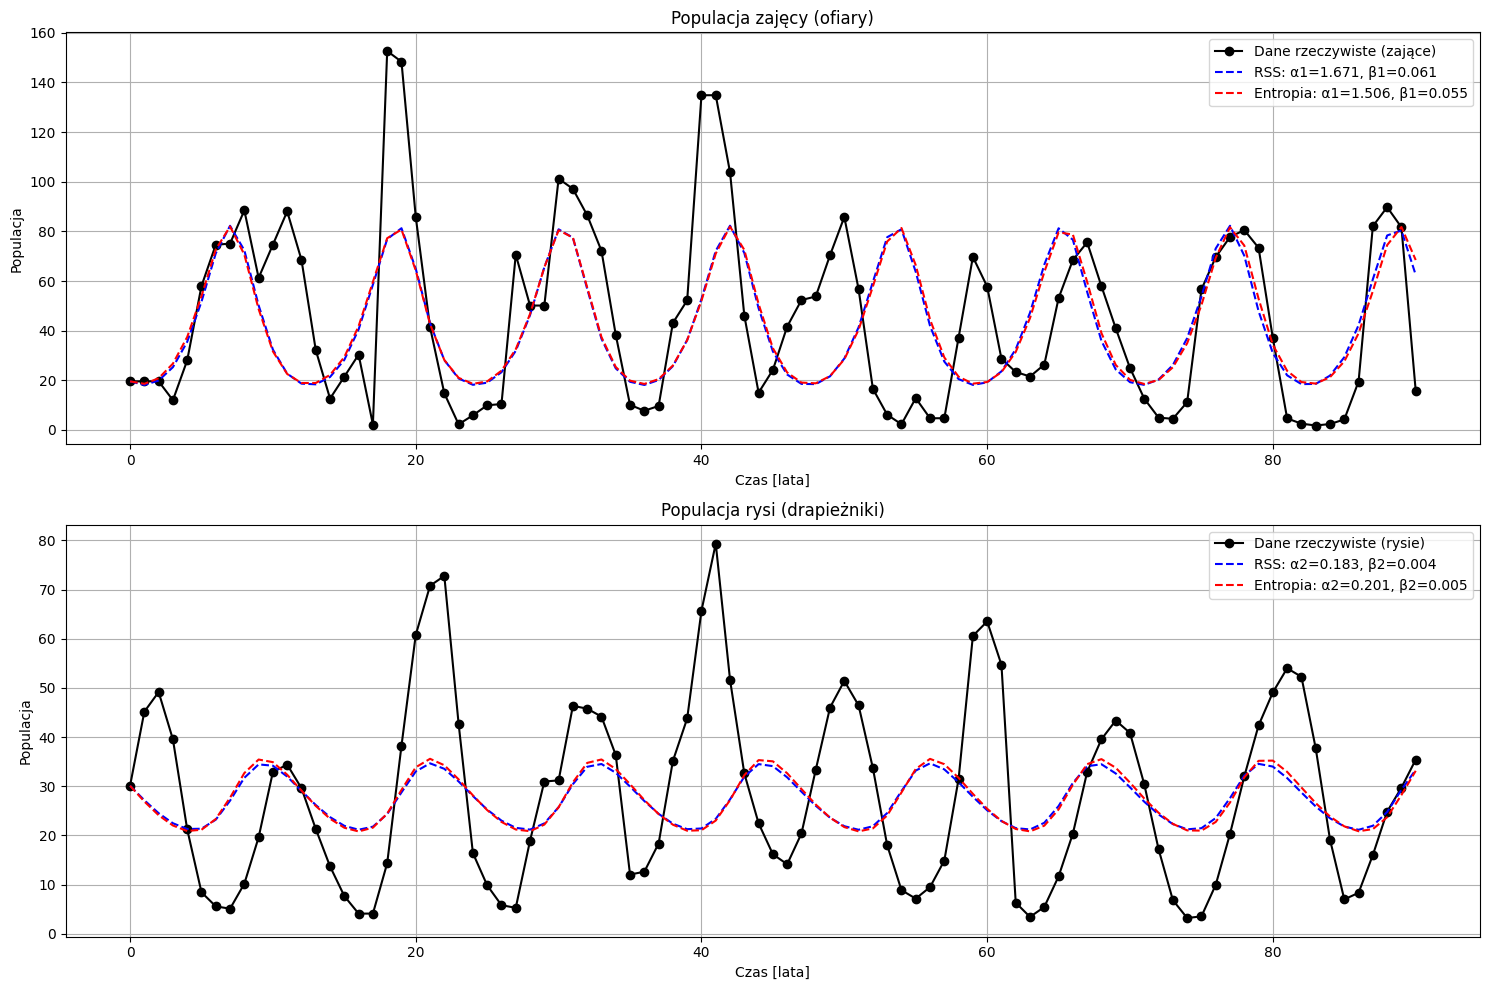

In [ ]:
def simulate_model(theta, t_data, x0, y0, steps_per_year=12):
    global alpha1, alpha2, beta1, beta2
    alpha1, alpha2, beta1, beta2 = theta
    
    # Oblicz całkowitą liczbę kroków
    total_time = t_data[-1] - t_data[0]
    num_steps = int(total_time * steps_per_year)
    h = total_time / num_steps
    
    # Inicjalizacja tablic wynikowych
    t_sim = np.linspace(t_data[0], t_data[-1], num_steps + 1)
    x_sim = np.zeros(num_steps + 1)
    y_sim = np.zeros(num_steps + 1)
    x_sim[0] = x0
    y_sim[0] = y0
    
    for i in range(num_steps):
        x, y = x_sim[i], y_sim[i]
        k1x = dx(x, y)
        k1y = dy(x, y)
        k2x = dx(x + 0.5*h*k1x, y + 0.5*h*k1y)
        k2y = dy(x + 0.5*h*k1x, y + 0.5*h*k1y)
        k3x = dx(x + 0.5*h*k2x, y + 0.5*h*k2y)
        k3y = dy(x + 0.5*h*k2x, y + 0.5*h*k2y)
        k4x = dx(x + h*k3x, y + h*k3y)
        k4y = dy(x + h*k3x, y + h*k3y)
        x_sim[i+1] = x + (h/6) * (k1x + 2*k2x + 2*k3x + k4x)
        y_sim[i+1] = y + (h/6) * (k1y + 2*k2y + 2*k3y + k4y)
    
    x_interp = np.interp(t_data, t_sim, x_sim)
    y_interp = np.interp(t_data, t_sim, y_sim)
    
    return x_interp, y_interp

def cost_rss(theta, t_data, hares, lynxes):
    x_sim, y_sim = simulate_model(theta, t_data, hares[0], lynxes[0])
    return np.sum((hares - x_sim)**2 + (lynxes - y_sim)**2)

def cost_entropy(theta, t_data, hares, lynxes):
    x_sim, y_sim = simulate_model(theta, t_data, hares[0], lynxes[0])
    epsilon = 1e-10  # Zabezpieczenie przed log(0)
    
    term1 = -np.sum(lynxes * np.log(y_sim + epsilon))
    term2 = -np.sum(hares * np.log(x_sim + epsilon))
    term3 = np.sum(y_sim)
    term4 = np.sum(x_sim)
    
    return term1 + term2 + term3 + term4

def estimate_parameters(t_data, hares, lynxes):
    initial_guess = [1.0, 0.5, 0.1, 0.02]
    
    result_rss = minimize(
        cost_rss, 
        initial_guess,
        args=(t_data, hares, lynxes),
        method='Nelder-Mead'
    )
    
    result_entropy = minimize(
        cost_entropy, 
        initial_guess,
        args=(t_data, hares, lynxes),
        method='Nelder-Mead'
    )
    
    return result_rss, result_entropy

def load_data(filename):
    data = np.loadtxt(filename)
    years = data[:, 0]
    hares = data[:, 1]
    lynxes = data[:, 2]
    
    # Normalizacja czasu: zaczynamy od t=0
    t_data = years - years[0]
    return t_data, hares, lynxes


t_data, hares, lynxes = load_data('LynxHare.txt')

result_rss, result_entropy = estimate_parameters(t_data, hares, lynxes)

print("Oszacowane parametry (RSS):")
print(f"α1 = {result_rss.x[0]:.4f}, α2 = {result_rss.x[1]:.4f}")
print(f"β1 = {result_rss.x[2]:.4f}, β2 = {result_rss.x[3]:.4f}")
print(f"Wartość funkcji kosztu: {result_rss.fun:.2f}")

print("\nOszacowane parametry (Entropia):")
print(f"α1 = {result_entropy.x[0]:.4f}, α2 = {result_entropy.x[1]:.4f}")
print(f"β1 = {result_entropy.x[2]:.4f}, β2 = {result_entropy.x[3]:.4f}")
print(f"Wartość funkcji kosztu: {result_entropy.fun:.2f}")

theta_rss = result_rss.x
theta_entropy = result_entropy.x

x_rss, y_rss = simulate_model(theta_rss, t_data, hares[0], lynxes[0])
x_entropy, y_entropy = simulate_model(theta_entropy, t_data, hares[0], lynxes[0])

plt.figure(figsize=(15, 10))

# Wykres populacji zajęcy
plt.subplot(2, 1, 1)
plt.plot(t_data, hares, 'ko-', label='Dane rzeczywiste (zające)')
plt.plot(t_data, x_rss, 'b--', label=f'RSS: α1={theta_rss[0]:.3f}, β1={theta_rss[2]:.3f}')
plt.plot(t_data, x_entropy, 'r--', label=f'Entropia: α1={theta_entropy[0]:.3f}, β1={theta_entropy[2]:.3f}')
plt.title('Populacja zajęcy (ofiary)')
plt.xlabel('Czas [lata]')
plt.ylabel('Populacja')
plt.legend()
plt.grid(True)

# Wykres populacji rysi
plt.subplot(2, 1, 2)
plt.plot(t_data, lynxes, 'ko-', label='Dane rzeczywiste (rysie)')
plt.plot(t_data, y_rss, 'b--', label=f'RSS: α2={theta_rss[1]:.3f}, β2={theta_rss[3]:.3f}')
plt.plot(t_data, y_entropy, 'r--', label=f'Entropia: α2={theta_entropy[1]:.3f}, β2={theta_entropy[3]:.3f}')
plt.title('Populacja rysi (drapieżniki)')
plt.xlabel('Czas [lata]')
plt.ylabel('Populacja')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()